# 1. 기본 설정

In [ ]:
! pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.9 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import random
import os
import gc
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import *
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
import warnings
warnings.simplefilter('ignore')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(42) # Seed 고정

### data 불러오기

In [ ]:
def csv_to_parquet(csv_path, save_name):
    df = pd.read_csv(csv_path)
    df.to_parquet(f'./{save_name}.parquet')
    del df
    gc.collect()
    print(save_name, 'Done.')

In [ ]:
csv_to_parquet('/content/drive/MyDrive/항공기 지연 예측(Dacon)/data/train_.csv', 'train')
csv_to_parquet('/content/drive/MyDrive/항공기 지연 예측(Dacon)/data/test.csv', 'test')

train Done.
test Done.


In [ ]:
train = pd.read_parquet('./train.parquet')
test = pd.read_parquet('./test.parquet')
sample_submission = pd.read_csv('/content/drive/MyDrive/항공기 지연 예측(Dacon)/data/sample_submission.csv', index_col = 0)

**column**
*   ID : 샘플 고유 id
*  Month: 해당 항공편의 출발 월
* Day_of_Month: Month에 해당하는 월의 날짜
* Estimated_Departure_Time: 전산 시스템을 바탕으로 측정된 비행기의 출발 시간 (현지 시각, HH:MM 형식)
* Estimated_Arrival_Time: 전산 시스템을 바탕으로 측정된 비행기의 도착 시간 (현지 시각, HH:MM 형식)
* Cancelled: 해당 항공편의 취소 여부 (0: 취소되지 않음, 1: 취소됨)
* Diverted: 해당 항공편의 경유 여부 (0: 취소되지 않음, 1: 취소됨)
* Origin_Airport: 해당 항공편 출발 공항의 고유 코드 (IATA 공항 코드)
* Origin_Airport_ID: 해당 항공편 출발 공항의 고유 ID (US DOT ID)
* Origin_State: 해당 항공편 출발 공항이 위치한 주의 이름
* Destination_Airport: 해당 항공편 도착 공항의 고유 코드 (IATA 공항 코드)
* Destination_Airport_ID: 해당 항공편 도착 공항의 고유 ID (US DOT ID)
* Destination_State: 해당 항공편 도착 공항이 위치한 주의 이름
* Distance: 출발 공항과 도착 공항 사이의 거리 (mile 단위)
* Airline: 해당 항공편을 운항하는 항공사
* Carrier_Code(IATA): 해당 항공편을 운항하는 항공사의 고유 코드
(IATA 공항 코드, 단 다른 항공사가 같은 코드를 보유할 수도 있음)
* Carrier_ID(DOT): 해당 항공편을 운항하는 항공사의 고유 ID (US DOT ID)
* Tail_Number: 해당 항공편을 운항하는 항공기의 고유 등록번호
* Delay: 항공편 지연 여부 (Not_Delayed, Delayed)<br>
    - **예측해야 하는 타깃**<br>
    - 다수의 데이터에 레이블이 존재하지 않음<br>
    - 준지도학습을 통해 레이블링 가능

# Data Pre-Processing

## 결측치 개수 확인

In [ ]:
print(train.isna().sum())
print('-'*50)
print(train.isna().sum() / train.shape[0])

ID                               0
Month                            0
Day_of_Month                     0
Estimated_Departure_Time    109019
Estimated_Arrival_Time      109040
Cancelled                        0
Diverted                         0
Origin_Airport                   0
Origin_Airport_ID                0
Origin_State                109015
Destination_Airport              0
Destination_Airport_ID           0
Destination_State           109079
Distance                         0
Airline                     108920
Carrier_Code(IATA)          108990
Carrier_ID(DOT)             108997
Tail_Number                      0
Delay                       744999
dtype: int64
--------------------------------------------------
ID                          0.000000
Month                       0.000000
Day_of_Month                0.000000
Estimated_Departure_Time    0.109019
Estimated_Arrival_Time      0.109040
Cancelled                   0.000000
Diverted                    0.000000
Origin_Airpo

In [ ]:
target = 'Delay'
train[target].isna().sum()

744999

## 모두 같은 값을 가지는 열 제거

In [ ]:
# 값이 모두 0임
train['Cancelled'].value_counts(), train['Diverted'].value_counts()

(0    1000000
 Name: Cancelled, dtype: int64,
 0    1000000
 Name: Diverted, dtype: int64)

In [ ]:
train = train.drop(['Cancelled', 'Diverted'], axis=1)
test = test.drop(['Cancelled', 'Diverted'], axis=1)

### 결측치 채우기

#### 1:1 대응으로 채우기

In [ ]:
# Origin_Airport_ID가 같은 값으로 Airline 채우기
for i in range(len(train)):
    if train['Airline'][i] == None:
        for j in range(len(train)):
            if train['Tail_Number'][i] == train['Tail_Number'][j] :
                train.loc[i, 'Airline'] = train['Airline'][j]
                break
            else:
                pass


train_state = train.groupby(by = ['Origin_State', 'Origin_Airport_ID', 'Destination_State', 'Destination_Airport_ID'], as_index = False)[['ID']].count()

# Origin_Airport_ID가 같은 값으로 Origin_State 채우기
for i in range(len(train)):
    if train['Origin_State'][i] == None:
        for j in range(len(train_state)):
            if train['Origin_Airport_ID'][i] == train_state['Origin_Airport_ID'][j] :
                train.loc[i, 'Origin_State'] = train_state['Origin_State'][j]
                break
            else:
                pass

tail = train.groupby(['Airline', 'Carrier_ID(DOT)'], as_index= False)[['ID']].count()

count = 0
for i in tail['Carrier_ID(DOT)'].value_counts():
    if i != 1 :
        count += 1
    else :
        pass


train.loc[train['Airline'].isna(), 'Airline'] = 'isnull'
train.loc[train['Airline']== 'isnull', 'Airline'] = None


for i in range(len(train)):
    if train['Airline'][i] == None:
        for j in range(len(tail)):
            if train['Carrier_ID(DOT)'][i] == tail['Carrier_ID(DOT)'][j] :
                train.loc[i, 'Airline'] = tail['Airline'][j]
                break
            else:
                pass


# Airline과 Carrier_ID(DOT)의 결측치를 1:1대응으로 채우기

# 결측값을 None으로 바꿔주기
train.loc[train['Carrier_ID(DOT)'].isna(), 'Carrier_ID(DOT)'] = 'isnull'
train.loc[train['Carrier_ID(DOT)']== 'isnull', 'Carrier_ID(DOT)'] = None

for i in range(len(train)):
    if train['Carrier_ID(DOT)'][i] == None:
        count = 0
        for j in range(len(tail)):
            if train['Airline'][i] == tail['Airline'][j] :
                train.loc[i, 'Carrier_ID(DOT)'] = tail['Carrier_ID(DOT)'][j]
                break
            else:
                count += 1
                pass

train_state = train.groupby(by = ['Origin_State', 'Origin_Airport_ID', 'Destination_State', 'Destination_Airport_ID'], as_index = False)[['ID']].count()

for i in range(1,len(train)):
    if train['Destination_State'][i] == None:
        count = 0
        for j in range(1,len(train_state)):
            if train['Destination_Airport_ID'][i] == train_state['Destination_Airport_ID'][j] :
                train.loc[i, 'Destination_State'] = train_state['Destination_State'][j]
                break
            else:
                count += 1
                pass

#1 : 1 대응 변수 삭제
train = train.drop(['Origin_Airport_ID', 'Destination_Airport_ID', 'Carrier_Code(IATA)', 'Cancelled', 'Diverted'], axis = 1)

# Origin_Airport_ID가 같은 값으로 Origin_State 채우기
for i in range(len(train)):
    if train['Origin_State'][i] == None:
        for j in range(len(train_state)):
            if train['Origin_Airport_ID'][i] == train_state['Origin_Airport_ID'][j] :
                train.loc[i, 'Origin_State'] = train_state['Origin_State'][j]
                break
            else:
                pass

tail = train.groupby(['Airline', 'Carrier_ID(DOT)'], as_index= False)[['ID']].count()

count = 0
for i in tail['Carrier_ID(DOT)'].value_counts():
    if i != 1 :
        count += 1
    else :
        pass

train.loc[train['Airline'].isna(), 'Airline'] = 'isnull'
train.loc[train['Airline']== 'isnull', 'Airline'] = None


for i in range(len(train)):
    if train['Airline'][i] == None:
        for j in range(len(tail)):
            if train['Carrier_ID(DOT)'][i] == tail['Carrier_ID(DOT)'][j] :
                train.loc[i, 'Airline'] = tail['Airline'][j]
                break
            else:
                pass

# Airline과 Carrier_ID(DOT)의 결측치를 1:1대응으로 채우기

# 결측값을 None으로 바꿔주기
train.loc[train['Carrier_ID(DOT)'].isna(), 'Carrier_ID(DOT)'] = 'isnull'
train.loc[train['Carrier_ID(DOT)']== 'isnull', 'Carrier_ID(DOT)'] = None

for i in range(len(train)):
    if train['Carrier_ID(DOT)'][i] == None:
        count = 0
        for j in range(len(tail)):
            if train['Airline'][i] == tail['Airline'][j] :
                train.loc[i, 'Carrier_ID(DOT)'] = tail['Carrier_ID(DOT)'][j]
                break
            else:
                count += 1
                pass

train_state = train.groupby(by = ['Origin_State', 'Origin_Airport_ID', 'Destination_State', 'Destination_Airport_ID'], as_index = False)[['ID']].count()

for i in range(1,len(train)):
    if train['Destination_State'][i] == None:
        count = 0
        for j in range(1,len(train_state)):
            if train['Destination_Airport_ID'][i] == train_state['Destination_Airport_ID'][j] :
                train.loc[i, 'Destination_State'] = train_state['Destination_State'][j]
                break
            else:
                count += 1
                pass

#1 : 1 대응 변수 삭제
train = train.drop(['Origin_Airport_ID', 'Destination_Airport_ID', 'Carrier_Code(IATA)'], axis = 1)

a = train.loc[train['Estimated_Departure_Time'].isna() & train['Estimated_Arrival_Time'].isna()]
train = train.drop(a.index , axis = 0)


In [ ]:
test_state = test.groupby(by = ['Origin_State', 'Origin_Airport_ID', 'Destination_State', 'Destination_Airport_ID'], as_index = False)[['ID']].count()

# Origin_Airport_ID가 같은 값으로 Origin_State 채우기
for i in range(len(test)):
    if test['Origin_State'][i] == None:
        for j in range(len(test_state)):
            if test['Origin_Airport_ID'][i] == test_state['Origin_Airport_ID'][j] :
                test.loc[i, 'Origin_State'] = test_state['Origin_State'][j]
                break
            else:
                pass

tail = test.groupby(['Airline', 'Carrier_ID(DOT)'], as_index= False)[['ID']].count()

count = 0
for i in tail['Carrier_ID(DOT)'].value_counts():
    if i != 1 :
        count += 1
    else :
        pass


test.loc[test['Airline'].isna(), 'Airline'] = 'isnull'
test.loc[test['Airline']== 'isnull', 'Airline'] = None


for i in range(len(test)):
    if test['Airline'][i] == None:
        for j in range(len(tail)):
            if test['Carrier_ID(DOT)'][i] == tail['Carrier_ID(DOT)'][j] :
                test.loc[i, 'Airline'] = tail['Airline'][j]
                break
            else:
                pass


# Airline과 Carrier_ID(DOT)의 결측치를 1:1대응으로 채우기

# 결측값을 None으로 바꿔주기
test.loc[test['Carrier_ID(DOT)'].isna(), 'Carrier_ID(DOT)'] = 'isnull'
test.loc[test['Carrier_ID(DOT)']== 'isnull', 'Carrier_ID(DOT)'] = None

for i in range(len(test)):
    if test['Carrier_ID(DOT)'][i] == None:
        count = 0
        for j in range(len(tail)):
            if test['Airline'][i] == tail['Airline'][j] :
                test.loc[i, 'Carrier_ID(DOT)'] = tail['Carrier_ID(DOT)'][j]
                break
            else:
                count += 1
                pass

test_state = test.groupby(by = ['Origin_State', 'Origin_Airport_ID', 'Destination_State', 'Destination_Airport_ID'], as_index = False)[['ID']].count()

for i in range(1,len(test)):
    if test['Destination_State'][i] == None:
        count = 0
        for j in range(1,len(test_state)):
            if test['Destination_Airport_ID'][i] == test_state['Destination_Airport_ID'][j] :
                test.loc[i, 'Destination_State'] = test_state['Destination_State'][j]
                break
            else:
                count += 1
                pass

#1 : 1 대응 변수 삭제
test = test.drop(['Origin_Airport_ID', 'Destination_Airport_ID', 'Carrier_Code(IATA)', 'Cancelled', 'Diverted'], axis = 1)

# Origin_Airport_ID가 같은 값으로 Origin_State 채우기
for i in range(len(test)):
    if test['Origin_State'][i] == None:
        for j in range(len(test_state)):
            if test['Origin_Airport_ID'][i] == test_state['Origin_Airport_ID'][j] :
                test.loc[i, 'Origin_State'] = test_state['Origin_State'][j]
                break
            else:
                pass

tail = test.groupby(['Airline', 'Carrier_ID(DOT)'], as_index= False)[['ID']].count()

count = 0
for i in tail['Carrier_ID(DOT)'].value_counts():
    if i != 1 :
        count += 1
    else :
        pass

test.loc[test['Airline'].isna(), 'Airline'] = 'isnull'
test.loc[test['Airline']== 'isnull', 'Airline'] = None


for i in range(len(test)):
    if test['Airline'][i] == None:
        for j in range(len(tail)):
            if test['Carrier_ID(DOT)'][i] == tail['Carrier_ID(DOT)'][j] :
                test.loc[i, 'Airline'] = tail['Airline'][j]
                break
            else:
                pass

# Airline과 Carrier_ID(DOT)의 결측치를 1:1대응으로 채우기

# 결측값을 None으로 바꿔주기
test.loc[test['Carrier_ID(DOT)'].isna(), 'Carrier_ID(DOT)'] = 'isnull'
test.loc[test['Carrier_ID(DOT)']== 'isnull', 'Carrier_ID(DOT)'] = None

for i in range(len(test)):
    if test['Carrier_ID(DOT)'][i] == None:
        count = 0
        for j in range(len(tail)):
            if test['Airline'][i] == tail['Airline'][j] :
                test.loc[i, 'Carrier_ID(DOT)'] = tail['Carrier_ID(DOT)'][j]
                break
            else:
                count += 1
                pass

test_state = test.groupby(by = ['Origin_State', 'Origin_Airport_ID', 'Destination_State', 'Destination_Airport_ID'], as_index = False)[['ID']].count()

for i in range(1,len(test)):
    if test['Destination_State'][i] == None:
        count = 0
        for j in range(1,len(test_state)):
            if test['Destination_Airport_ID'][i] == test_state['Destination_Airport_ID'][j] :
                test.loc[i, 'Destination_State'] = test_state['Destination_State'][j]
                break
            else:
                count += 1
                pass

#1 : 1 대응 변수 삭제
test = test.drop(['Origin_Airport_ID', 'Destination_Airport_ID', 'Carrier_Code(IATA)'], axis = 1)

a = test.loc[test['Estimated_Departure_Time'].isna() & test['Estimated_Arrival_Time'].isna()]
test = test.drop(a.index , axis = 0)


#### KNN imputer

In [ ]:
# Estimated_Departure_Time, Estimated_Arrival_Time KNNImputer 사용
imputer = KNNImputer(n_neighbors=2)

train['Estimated_Departure_Time'] = imputer.fit_transform(train[['Estimated_Departure_Time']])
train['Estimated_Arrival_Time'] = imputer.fit_transform(train[['Estimated_Arrival_Time']])


In [ ]:
test['Estimated_Departure_Time'] = imputer.fit_transform(test[['Estimated_Departure_Time']])
test['Estimated_Arrival_Time'] = imputer.fit_transform(test[['Estimated_Arrival_Time']])

#### 최빈값으로 채우기

In [ ]:
#레이블(Delay)을 제외한 결측값이 존재하는 변수들을 학습 데이터의 최빈값으로 대체합니다
NaN_col = ['Airline','Carrier_ID(DOT)', 'Destination_State']

for col in NaN_col:
    mode = train[col].mode()[0]
    train[col] = train[col].fillna(mode)


In [ ]:
for col in NaN_col:
    mode = test[col].mode()[0]
    test[col] = test[col].fillna(mode)


### 파생변수 생성

In [ ]:
# 총 소요시간
train['Total_Time'] = None
for i in range(len(train)):
    if train['Estimated_Departure_Time'][i] > train['Estimated_Arrival_Time'][i] :
        train.loc[i, 'Total_Time'] = 2400-(train['Estimated_Arrival_Time'][i] - train['Estimated_Departure_Time'][i])
    else :
        train.loc[i, 'Total_Time'] = train['Estimated_Arrival_Time'][i] - train['Estimated_Departure_Time'][i]

test['Total_Time'] = None
for i in range(len(test)):
    if test['Estimated_Departure_Time'][i] > test['Estimated_Arrival_Time'][i] :
        test.loc[i, 'Total_Time'] = 2400-(test['Estimated_Arrival_Time'][i] - test['Estimated_Departure_Time'][i])
    else :
        test.loc[i, 'Total_Time'] = test['Estimated_Arrival_Time'][i] - test['Estimated_Departure_Time'][i]

In [ ]:
#시간과 분
train['Departure_Time'] = train['Estimated_Departure_Time'].apply(lambda x: int(x/100))
train['Departure_Minute'] = train['Estimated_Departure_Time'].apply(lambda x: int(x%100))
test['Departure_Time'] = test['Estimated_Departure_Time'].apply(lambda x: int(x/100))
test['Departure_Minute'] = test['Estimated_Departure_Time'].apply(lambda x: int(x%100))

train['Arrival_Hour'] = train['Estimated_Arrival_Time'].apply(lambda x: int(x/100))
train['Arrival_Minute'] = train['Estimated_Arrival_Time'].apply(lambda x: int(x%100))
test['Arrival_Hour'] = test['Estimated_Arrival_Time'].apply(lambda x: int(x/100))
test['Arrival_Minute'] = test['Estimated_Arrival_Time'].apply(lambda x: int(x%100))


In [ ]:
#시간 범주화

train.loc[(train['Departure_Time'] >=0) & (train['Departure_Time'] < 3), 'Departure_Time'] = 1
train.loc[(train['Departure_Time'] >= 3) & (train['Departure_Time'] < 6), 'Departure_Time'] = 2
train.loc[(train['Departure_Time'] >= 6) & (train['Departure_Time'] < 9), 'Departure_Time'] = 3
train.loc[(train['Departure_Time'] >= 9) & (train['Departure_Time'] < 12), 'Departure_Time'] = 4
train.loc[(train['Departure_Time'] >= 12) & (train['Departure_Time'] < 15), 'Departure_Time'] = 5
train.loc[(train['Departure_Time'] >= 15) & (train['Departure_Time'] < 18), 'Departure_Time'] = 6
train.loc[(train['Departure_Time'] >= 18) & (train['Departure_Time'] < 21), 'Departure_Time'] = 7
train.loc[train['Departure_Time'] >= 21 , 'Departure_Time'] = 8

test.loc[(test['Departure_Time'] >= 0) & (test['Departure_Time'] < 3), 'Departure_Time'] = 1
test.loc[(test['Departure_Time'] >= 3) & (test['Departure_Time'] < 6), 'Departure_Time'] = 2
test.loc[(test['Departure_Time'] >= 6) & (test['Departure_Time'] < 9), 'Departure_Time'] = 3
test.loc[(test['Departure_Time'] >= 9) & (test['Departure_Time'] < 12), 'Departure_Time'] = 4
test.loc[(test['Departure_Time'] >= 12) & (test['Departure_Time'] < 15), 'Departure_Time'] = 5
test.loc[(test['Departure_Time'] >= 15) & (test['Departure_Time'] < 18), 'Departure_Time'] = 6
test.loc[(test['Departure_Time'] >= 18) & (test['Departure_Time'] < 21), 'Departure_Time'] = 7
test.loc[test['Departure_Time'] >= 21,'Departure_Time'] = 8

train.loc[(train['Arrival_Hour'] >=0) & (train['Arrival_Hour'] < 3), 'Arrival_Time'] = 1
train.loc[(train['Arrival_Hour'] >= 3) & (train['Arrival_Hour'] < 6), 'Arrival_Time'] = 2
train.loc[(train['Arrival_Hour'] >= 6) & (train['Arrival_Hour'] < 9), 'Arrival_Time'] = 3
train.loc[(train['Arrival_Hour'] >= 9) & (train['Arrival_Hour'] < 12), 'Arrival_Time'] = 4
train.loc[(train['Arrival_Hour'] >= 12) & (train['Arrival_Hour'] < 15), 'Arrival_Time'] = 5
train.loc[(train['Arrival_Hour'] >= 15) & (train['Arrival_Hour'] < 18), 'Arrival_Time'] = 6
train.loc[(train['Arrival_Hour'] >= 18) & (train['Arrival_Hour'] < 21), 'Arrival_Time'] = 7
train.loc[train['Arrival_Hour'] >= 21 , 'Arrival_Time'] = 8

test.loc[(test['Arrival_Hour'] >= 0) & (test['Arrival_Hour'] < 3), 'Arrival_Time'] = 1
test.loc[(test['Arrival_Hour'] >= 3) & (test['Arrival_Hour'] < 6), 'Arrival_Time'] = 2
test.loc[(test['Arrival_Hour'] >= 6) & (test['Arrival_Hour'] < 9), 'Arrival_Time'] = 3
test.loc[(test['Arrival_Hour'] >= 9) & (test['Arrival_Hour'] < 12), 'Arrival_Time'] = 4
test.loc[(test['Arrival_Hour'] >= 12) & (test['Arrival_Hour'] < 15), 'Arrival_Time'] = 5
test.loc[(test['Arrival_Hour'] >= 15) & (test['Arrival_Hour'] < 18), 'Arrival_Time'] = 6
test.loc[(test['Arrival_Hour'] >= 18) & (test['Arrival_Hour'] < 21), 'Arrival_Time'] = 7
test.loc[test['Arrival_Hour'] >= 21,'Arrival_Time'] = 8


In [ ]:
#불필요한 행 제거
train = train.drop(['Estimated_Departure_Time', 'Estimated_Arrival_Time', 'Day_of_Month','Tail_Number','Departure_Hour', 'Departure_Minute', 'Arrival_Hour', 'Arrival_Minute'], axis = 1)
test = test.drop(['Estimated_Departure_Time','Estimated_Arrival_Time', 'Day_of_Month', 'Tail_Number','Departure_Hour', 'Departure_Minute','Arrival_Hour', 'Arrival_Minute'], axis = 1)


## 범주화
이산형 변수 값 많은 것 > 빈도형 더미화\
아닌 변수 > get_dummies

### 빈도형 더미화
'Origin_Airport', 'Origin_State', 'Destination_Airport', 'Destination_State', 'Airline', 'Carrier_ID(DOT)'

In [ ]:
target = 'Delay'
X = train.drop(target, axis = 1)
y = train[target]

In [ ]:
df = pd.concat([X,test], axis = 0)
FEdf = df.loc[:,['Origin_Airport', 'Origin_State','Destination_Airport', 'Destination_State', 'Airline','Carrier_ID(DOT)']]
x_train_fe = X.loc[:,['Origin_Airport', 'Origin_State','Destination_Airport', 'Destination_State', 'Airline','Carrier_ID(DOT)']]
test_fe = test.loc[:, ['Origin_Airport', 'Origin_State','Destination_Airport', 'Destination_State', 'Airline','Carrier_ID(DOT)']]
for col in FEdf.columns:
    freq = FEdf[col].value_counts()
    x_train_fe[col] = x_train_fe[col].map(freq)
    test_fe[col] = test_fe[col].map(freq)

In [ ]:
test_fe_y = test.loc[:,['Month','Distance', 'Total_Time', 'Departure_Time', 'Arrival_Time']].reset_index()
test_z = pd.merge(test_fe_y, test_fe.reset_index(), on= 'index', how = 'inner')
test_z = test_z.drop('index', axis = 1)

x_train_fe_y = X.loc[:,['Month','Distance', 'Total_Time','Departure_Time', 'Arrival_Time']].reset_index()
x_train_fe= pd.merge(x_train_fe_y, x_train_fe.reset_index(), on= 'index', how = 'inner')
x_train_z = x_train_fe.drop('index', axis = 1)

### one-hot encoding
'Month','Departure_Hour', 'Arrival_Hour'

In [ ]:
train.head(3)

,Month,Origin_Airport,Origin_State,Destination_Airport,Destination_State,Distance,Airline,Carrier_ID(DOT),Delay,Total_Time,Departure_Time,Arrival_Time
0,8,256,11,331,45,1250.0,22,12,None,284.0,3.0,4.0
1,9,74,31,204,30,544.0,3,4,None,195.0,6.0,7.0
2,7,195,4,119,28,2454.0,26,6,None,830.0,4.0,6.0


In [ ]:
a = 'Month','Departure_Time', 'Arrival_Time'
train_dummy = X.loc[:, a]
train_dummy = train_dummy.astype(str)
train_dummy = pd.get_dummies(train_dummy, drop_first= True).reset_index()
test_dummy = test.loc[:, a]
test_dummy = test_dummy.astype(str)
test_dummy = pd.get_dummies(test_dummy, drop_first= True).reset_index()

x_train_fe_y = X.drop(['Month','Departure_Time', 'Arrival_Time'], axis = 1).reset_index()
x_train_k = pd.merge(x_train_fe_y, train_dummy, on= 'index', how = 'inner')
test_fe_y = test.drop(['Month','Departure_Time', 'Arrival_Time'], axis = 1).reset_index()
test_k = pd.merge(test_fe_y, test_dummy, on= 'index', how = 'inner')

x_train_k = x_train_k.drop('index', axis = 1)
test_k = test_k.drop('index', axis = 1)

In [ ]:
x_train_k.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 988312 entries, 0 to 988311
Data columns (total 33 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Origin_Airport       988312 non-null  int64  
 1   Origin_State         988312 non-null  int64  
 2   Destination_Airport  988312 non-null  int64  
 3   Destination_State    988312 non-null  int64  
 4   Distance             988312 non-null  float64
 5   Airline              988312 non-null  int64  
 6   Carrier_ID(DOT)      988312 non-null  int64  
 7   Total_Time           988312 non-null  float64
 8   Month_10             988312 non-null  uint8  
 9   Month_11             988312 non-null  uint8  
 10  Month_12             988312 non-null  uint8  
 11  Month_2              988312 non-null  uint8  
 12  Month_3              988312 non-null  uint8  
 13  Month_4              988312 non-null  uint8  
 14  Month_5              988312 non-null  uint8  
 15  Month_6          

## 정규화

### MinMaxScaler

In [ ]:
mm = MinMaxScaler()

x_train_k['Distance'] = mm.fit_transform(x_train_k['Distance'].values.reshape(-1, 1))
test_k['Distance'] = mm.transform(test_k['Distance'].values.reshape(-1, 1))

x_train_mm = pd.DataFrame(x_train_k)
test_mm = pd.DataFrame(test_k)

In [ ]:
train = pd.concat([x_train_mm, y] , axis = 1)

In [ ]:
train.head(3)

,Origin_Airport,Origin_State,Destination_Airport,Destination_State,Distance,Airline,Carrier_ID(DOT),Total_Time,Month_10,Month_11,...,Departure_Time_7.0,Departure_Time_8.0,Arrival_Time_2.0,Arrival_Time_3.0,Arrival_Time_4.0,Arrival_Time_5.0,Arrival_Time_6.0,Arrival_Time_7.0,Arrival_Time_8.0,Delay
0,256,11,331,45,0.242961,22,12,284.0,0,0,...,0,0,0,0,1,0,0,0,0,None
1,74,31,204,30,0.103957,3,4,195.0,0,0,...,0,0,0,0,0,0,0,1,0,None
2,195,4,119,28,0.480016,26,6,830.0,0,0,...,0,0,0,0,0,0,1,0,0,None


In [ ]:
test_mm.head(3)

,Origin_Airport,Origin_State,Destination_Airport,Destination_State,Distance,Airline,Carrier_ID(DOT),Total_Time,Month_10,Month_11,...,Departure_Time_6.0,Departure_Time_7.0,Departure_Time_8.0,Arrival_Time_2.0,Arrival_Time_3.0,Arrival_Time_4.0,Arrival_Time_5.0,Arrival_Time_6.0,Arrival_Time_7.0,Arrival_Time_8.0
0,171,42,312,42,0.034456,26,6,366.026944,0,0,...,0,0,0,0,0,0,0,1,0,0
1,121,28,22,8,0.143729,9,3,215.000000,0,0,...,1,0,0,0,0,0,0,1,0,0
2,258,11,205,30,0.141170,26,6,315.000000,0,0,...,1,0,0,0,0,0,0,0,1,0


In [ ]:
train.to_csv('/content/drive/MyDrive/항공기 지연 예측(Dacon)/data/pre_train.csv', index = False)
test_mm.to_csv('/content/drive/MyDrive/항공기 지연 예측(Dacon)/data/pre_test.csv', index = False)

# target 나누기

In [ ]:
#결측치 값 찾아내기
target = 'Delay'
train_a = train.loc[(train['Delay'] == 'Not_Delayed') | (train['Delay'] == 'Delayed')]

X_labeled = train_a.drop(target, axis = 1)
y_labeled = train_a[target]

train_b = train.loc[(train['Delay'] != 'Not_Delayed') & (train['Delay'] != 'Delayed')]

X_unlabeled = train_b.drop(target, axis = 1)

# 모델 학습


## 비지도학습

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(X_labeled, y_labeled, train_size = 0.8, random_state= 2023)

### DecisionTree

In [ ]:
X_unlabeled_dt = X_unlabeled.copy()

In [ ]:
base_classifier = DecisionTreeClassifier()
param_grid = {
    'max_iter': [10, 20, 30, 40, 50],
    'threshold': np.arange(0.5, 1, 0.1)
}

grid_search_dt = GridSearchCV(
    estimator=SelfTrainingClassifier(base_classifier),
    param_grid=param_grid,
)

# 그리드 서치 수행
grid_search_dt.fit(x_train, y_train)

# 최적의 하이퍼파라미터 조합 출력
print("최적 하이퍼파라미터 조합:", grid_search_dt.best_params_)

# 최적 모델로 학습 및 평가 (테스트 데이터 필요)
best_model_dt = grid_search_dt.best_estimator_
best_model_dt.fit(x_train, y_train)
accuracy_dt = best_model_dt.score(x_val, y_val)

print("최적 모델 정확도:", accuracy_dt)

최적 하이퍼파라미터 조합: {'max_iter': 20, 'threshold': 0.7999999999999999}
최적 모델 정확도: 0.7123467079414216


### CatBoost

In [ ]:
X_unlabeled_cat = X_unlabeled.copy()

In [ ]:
base_classifier = CatBoostClassifier()
param_grid = {
    'max_iter': [10, 20, 30, 40, 50],
    'threshold': np.arange(0.5, 1, 0.1)
}

grid_search_cat = GridSearchCV(
    estimator=SelfTrainingClassifier(base_classifier),
    param_grid=param_grid,
)

# 그리드 서치
grid_search_cat.fit(x_train, y_train)

# 최적의 하이퍼파라미터 조합 출력
print("최적 하이퍼파라미터 조합:", grid_search_cat.best_params_)


best_model_cat = grid_search_cat.best_estimator_
best_model_cat.fit(x_train, y_train)
accuracy_cat = best_model_cat.score(x_val, y_val)

print("최적 모델 정확도:", accuracy_cat)

Streaming output truncated to the last 5000 lines.
6:	learn: 0.5129561	total: 366ms	remaining: 51.9s
7:	learn: 0.5028505	total: 428ms	remaining: 53.1s
8:	learn: 0.4946005	total: 479ms	remaining: 52.8s
9:	learn: 0.4874471	total: 530ms	remaining: 52.5s
10:	learn: 0.4816269	total: 570ms	remaining: 51.2s
11:	learn: 0.4769787	total: 619ms	remaining: 51s
12:	learn: 0.4732950	total: 674ms	remaining: 51.1s
13:	learn: 0.4703378	total: 721ms	remaining: 50.7s
14:	learn: 0.4675325	total: 773ms	remaining: 50.8s
15:	learn: 0.4652537	total: 826ms	remaining: 50.8s
16:	learn: 0.4632885	total: 879ms	remaining: 50.8s
17:	learn: 0.4619035	total: 930ms	remaining: 50.8s
18:	learn: 0.4605619	total: 993ms	remaining: 51.3s
19:	learn: 0.4593547	total: 1.05s	remaining: 51.3s
20:	learn: 0.4581912	total: 1.11s	remaining: 51.6s
21:	learn: 0.4573964	total: 1.16s	remaining: 51.7s
22:	learn: 0.4565236	total: 1.22s	remaining: 51.6s
23:	learn: 0.4558043	total: 1.26s	remaining: 51.1s
24:	learn: 0.4552159	total: 1.3s	rema

In [ ]:
print("최적 하이퍼파라미터 조합:", grid_search_cat.best_params_)

최적 하이퍼파라미터 조합: {'max_iter': 10, 'threshold': 0.5}


### RandomForest


In [ ]:
X_unlabeled_rf = X_unlabeled.copy()

In [ ]:
base_classifier = RandomForestClassifier()
param_grid = {
    'max_iter': [10, 20, 30, 40, 50],
    'threshold': np.arange(0.5, 1, 0.1)
}

grid_search_rf = GridSearchCV(
    estimator=SelfTrainingClassifier(base_classifier),
    param_grid=param_grid,
)

# 그리드 서치
grid_search_rf.fit(x_train, y_train)

# 최적의 하이퍼파라미터 조합 출력
print("최적 하이퍼파라미터 조합:", grid_search_rf.best_params_)


best_model_rf = grid_search_rf.best_estimator_
best_model_rf.fit(x_train, y_train)
accuracy_rf = best_model_rf.score(x_val, y_val)

print("최적 모델 정확도:", accuracy_rf)

## Voting

### Hard Voting

In [ ]:
X_unlabeled_vote = X_unlabeled.copy()

In [ ]:
vote_hard = VotingClassifier(estimators=[
    ('dt', best_model_dt),  # Decision Tree 모델
    ('rf', best_model_rf),  # Random Forest 모델
    ('cat', best_model_cat) # CatBoost 모델
], voting='hard')  # Hard 보팅 방식을 선택


vote_hard.fit(x_train, y_train)

Learning rate set to 0.099295
0:	learn: 0.6438628	total: 63.1ms	remaining: 1m 3s
1:	learn: 0.6051508	total: 115ms	remaining: 57.2s
2:	learn: 0.5743501	total: 171ms	remaining: 57s
3:	learn: 0.5500256	total: 220ms	remaining: 54.8s
4:	learn: 0.5308450	total: 268ms	remaining: 53.4s
5:	learn: 0.5160086	total: 314ms	remaining: 51.9s
6:	learn: 0.5037173	total: 364ms	remaining: 51.6s
7:	learn: 0.4939009	total: 417ms	remaining: 51.7s
8:	learn: 0.4860541	total: 474ms	remaining: 52.2s
9:	learn: 0.4797429	total: 522ms	remaining: 51.6s
10:	learn: 0.4748096	total: 570ms	remaining: 51.3s
11:	learn: 0.4705495	total: 624ms	remaining: 51.3s
12:	learn: 0.4671413	total: 673ms	remaining: 51.1s
13:	learn: 0.4644485	total: 724ms	remaining: 51s
14:	learn: 0.4619451	total: 776ms	remaining: 51s
15:	learn: 0.4601943	total: 854ms	remaining: 52.5s
16:	learn: 0.4587551	total: 902ms	remaining: 52.1s
17:	learn: 0.4574217	total: 950ms	remaining: 51.8s
18:	learn: 0.4563545	total: 1s	remaining: 51.7s
19:	learn: 0.455415

VotingClassifier(estimators=[('dt',
                              SelfTrainingClassifier(base_estimator=DecisionTreeClassifier(),
                                                     max_iter=40,
                                                     threshold=0.7)),
                             ('rf',
                              SelfTrainingClassifier(base_estimator=RandomForestClassifier(),
                                                     max_iter=30,
                                                     threshold=0.5)),
                             ('cat',
                              SelfTrainingClassifier(base_estimator=<catboost.core.CatBoostClassifier object at 0x7e70659998d0>,
                                                     threshold=0.5))])

In [ ]:
y_pred = vote_hard.predict(x_val)

hard_voting_accuracy = accuracy_score(y_val, y_pred)
print("Hard 보팅 모델의 정확도:", hard_voting_accuracy)

Hard 보팅 모델의 정확도: 0.8218637139341985


### Soft Voting

In [ ]:
vote_soft = VotingClassifier(estimators=[
    ('dt', best_model_dt),  # Decision Tree 모델
    ('rf', best_model_rf),  # Random Forest 모델
    ('cat', best_model_cat) # CatBoost 모델
], voting='soft')  # soft 보팅 방식을 선택


vote_soft.fit(x_train, y_train)

Learning rate set to 0.099295
0:	learn: 0.6438628	total: 60.6ms	remaining: 1m
1:	learn: 0.6051508	total: 107ms	remaining: 53.5s
2:	learn: 0.5743501	total: 164ms	remaining: 54.6s
3:	learn: 0.5500256	total: 211ms	remaining: 52.6s
4:	learn: 0.5308450	total: 256ms	remaining: 51s
5:	learn: 0.5160086	total: 301ms	remaining: 49.8s
6:	learn: 0.5037173	total: 348ms	remaining: 49.4s
7:	learn: 0.4939009	total: 399ms	remaining: 49.4s
8:	learn: 0.4860541	total: 457ms	remaining: 50.4s
9:	learn: 0.4797429	total: 508ms	remaining: 50.3s
10:	learn: 0.4748096	total: 555ms	remaining: 49.9s
11:	learn: 0.4705495	total: 607ms	remaining: 50s
12:	learn: 0.4671413	total: 653ms	remaining: 49.6s
13:	learn: 0.4644485	total: 702ms	remaining: 49.5s
14:	learn: 0.4619451	total: 751ms	remaining: 49.3s
15:	learn: 0.4601943	total: 800ms	remaining: 49.2s
16:	learn: 0.4587551	total: 857ms	remaining: 49.6s
17:	learn: 0.4574217	total: 904ms	remaining: 49.3s
18:	learn: 0.4563545	total: 969ms	remaining: 50.1s
19:	learn: 0.4554

VotingClassifier(estimators=[('dt',
                              SelfTrainingClassifier(base_estimator=DecisionTreeClassifier(),
                                                     max_iter=40,
                                                     threshold=0.7)),
                             ('rf',
                              SelfTrainingClassifier(base_estimator=RandomForestClassifier(),
                                                     max_iter=30,
                                                     threshold=0.5)),
                             ('cat',
                              SelfTrainingClassifier(base_estimator=<catboost.core.CatBoostClassifier object at 0x7e70659998d0>,
                                                     threshold=0.5))],
                 voting='soft')

## 정확도 비교

In [ ]:
# 검증 데이터를 사용하여 예측
y_pred = vote_soft.predict(x_val)

# 정확도 계산
accuracy_soft_vote = accuracy_score(y_val, y_pred)
print("Soft 보팅 모델의 정확도:", accuracy)

Soft 보팅 모델의 정확도: 0.7963448029527325


<Axes: >

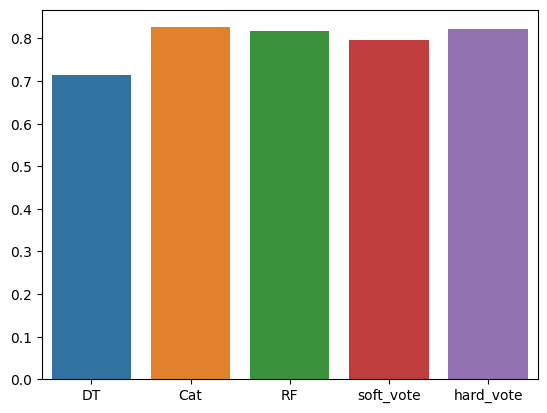

In [ ]:
acc = [accuracy_dt, accuracy_cat, accuracy_rf, accuracy_soft_vote, hard_voting_accuracy]
mod = ['DT', 'Cat', 'RF', 'soft_vote', 'hard_vote']

sns.barplot(x = mod, y = acc)
plt.title('정확도 비교')

In [ ]:
# 모델을 사용하여 예측
X_unlabeled_cat['Delay_pred'] = best_model_cat.predict(X_unlabeled_cat)


In [ ]:
# train_lb의 'Delay'칼럼값이 -1인 레이블값 예측값으로 채우기
for i in range(len(X_unlabeled_cat)):
  row_index=X_unlabeled_cat['Delay_pred'].index[i]
  train.loc[row_index,'Delay']=X_unlabeled_cat['Delay_pred'].iloc[i]

In [ ]:
train['Delay'].value_counts()

Not_Delayed    939084
Delayed         49228
Name: Delay, dtype: int64

In [ ]:
train.to_csv('/content/drive/MyDrive/항공기 지연 예측(Dacon)/data/train_semi.csv', index = False)

## oversampling

In [ ]:
x_train = train.drop('Delay', axis = 1)
y_train = train['Delay']

In [ ]:
pd.Series(y_train).value_counts()

Not_Delayed    939084
Delayed         49228
Name: Delay, dtype: int64

In [ ]:
smote = SMOTE()
s_x_train, s_y_train = smote.fit_resample(x_train, y_train)

In [ ]:
le = LabelEncoder()

y_train_encoded = le.fit_transform(y_train)
s_y_train_encoded = le.transform(s_y_train)
# Not_Delayed : 1 Delayed : 0
# 변환된 값 출력
print('전 : ', np.bincount(y_train_encoded))
print('후 : ', np.bincount(s_y_train_encoded))

전 :  [ 49228 939084]
후 :  [939084 939084]


<Axes: >

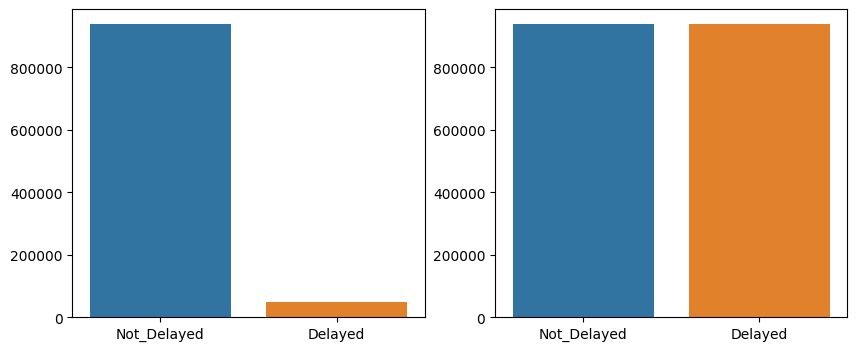

In [ ]:
plt.figure(figsize=(10, 4))
plt.subplot(1,2,1)
sns.barplot(x = pd.Series(y_train).value_counts().index, y = pd.Series(y_train).value_counts().values)
plt.subplot(1,2,2)
sns.barplot(x = pd.Series(s_y_train).value_counts().index, y = pd.Series(s_y_train).value_counts().values)

In [ ]:
s_x_train.to_csv('/content/drive/MyDrive/항공기 지연 예측(Dacon)/data/s_x_train.csv', index = False)
s_y_train.to_csv('/content/drive/MyDrive/항공기 지연 예측(Dacon)/datas_y_train.csv', index = False)

## 지도학습

###   Logistic Regression

In [ ]:
csv_to_parquet('/content/drive/MyDrive/항공기 지연 예측(Dacon)/data/s_x_train.csv', 's_x_train')
csv_to_parquet('/content/drive/MyDrive/항공기 지연 예측(Dacon)/data/s_y_train.csv', 's_y_train')
csv_to_parquet('/content/drive/MyDrive/항공기 지연 예측(Dacon)/data/pre_test.csv', 'test')
s_x_train = pd.read_parquet('./s_x_train.parquet')
s_y_train = pd.read_parquet('./s_y_train.parquet')
test = pd.read_parquet('./test.parquet')

s_x_train Done.
s_y_train Done.
test Done.


In [ ]:
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10],
}

grid_lr = GridSearchCV(LogisticRegression(), param_grid=param_grid, cv=5, scoring='accuracy')

grid_lr.fit(s_x_train, s_y_train)

print("최적 하이퍼파라미터 조합:", grid_lr.best_params_)

best_model_lr = grid_lr.best_estimator_
best_model_lr.fit(s_x_train, s_y_train)

최적 하이퍼파라미터 조합: {'C': 10, 'penalty': 'l2'}


LogisticRegression(C=10)

In [ ]:
y_pred_lr = best_model_lr.predict_proba(test)

# 제출

In [ ]:
sample_submission = pd.read_csv('/content/drive/MyDrive/항공기 지연 예측(Dacon)/data/.csv', index_col = 0)

In [ ]:
submission = pd.DataFrame(data=y_pred_lr, columns=sample_submission.columns, index=sample_submission.index)

In [ ]:
submission.head(3)

,Not_Delayed,Delayed
ID,,
TEST_000000,0.307236,0.692764
TEST_000001,0.064749,0.935251
TEST_000002,0.518262,0.481738


In [ ]:
submission.to_csv('/content/drive/MyDrive/항공기 지연 예측(Dacon)/data/submission.csv', index=True)